# Pendulum-2: Inverse Problem


## Theoretical Background

### Objective

In this tutorial we will train a simple neural netowrk to compute the value of acceleration due to gravity ($g$), using (artificial) experimental data obtained by observing the motion of a pendulum. This is what is termed as the **inverse problem**. 


### Motivation

One of the classical method for measuring the value of $g$ is by using a pendulum, as done by Galileo Galilei. He observed the time period of a pendulum of lenght $L$, and then back-calculating the value of $g$ using the simple equation: $ T = 2 \pi \sqrt{ L/g } $. But this equation is valid only for small values of pendulum displacement $\theta$. Go through this [aritcle](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html) for additional theoretical background and visualization.  For larger values of displacement $\theta$, the motion of the pendulum is given by the following ordinary differential equation (ODE):

$$ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0 } $$

Thus, for a pendulum under a large displacement $\theta$, we can use the observed pendulum displacement values to train a neural network, while simultaneously incorporating the aforementioned governing ODE into the loss function and keeping $g$ as a learnable parameter. Following are the primary benifits of using PINNs for such inverse problems:
- Allows us to **work with the actual ODE**, instead of the simplifying equation (based on assumptions).
- Allows us to use **lesser training data** (just 51 data-points in this example). 



### Methodology

Let us consider a simple pendulum of lenght $L = 0.5\ m$ and initial displacement $\theta_0 = 45\degree$. Thus, we can state the following regarding our system:

**Initial Condition 1 :**
$$ \theta_{0} = 45\degree $$

**Initial Condition 2 :**
$$ \displaystyle{ \omega_0 = 0\ rad/s } $$

**Governing Equation :**
$$ \displaystyle{ \frac{d^2\theta}{dt^2} + \frac{g}{L} \sin \theta = 0 } $$

<br>

Since we are assuming the pendulum to be stationary at the initial position ($t=0$), its angular velocity is also zeros ( $\omega_0 = d\theta_0/dt = 0$), which serves as our second initial condition (I.C). The governing equation, which is an ODE, must be satisfied for all time $t \ge 0$. We will solve the governing ODE (for the give I.C) using the well known **RK45 numerical method**, in the time domain $t \in [0,\ 5]$. This will be computed for a time-step of $0.01\ s$. In the numerical solution of the ODE we will assume the value $g = 9.81\ m/s^2$. We will then extract uniformly spaced samples at $0.1\ s$ interval and use this as our (artificial) experimental data for training the neural network. This training data along with the aforementioned I.Cs and  governing ODE will be the **loss function** of the neural network. Note: the value of $g$ used in the governing equation for loss function will be a *learnable parameter* that the neural network will update (using backpropagation) in each iteration. 

**In summary :**
- $g$ is a *learnable parameter* for the neural network.
- Loss function:
    - Training data from the (artificail) experiment.
    - Initial conditions (I.C) and governing ODE.


## Import Libraries

In [1]:
# For numerical method
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# For PINNs
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


## Numerical Method (RK45)


We will first solve the governing ODE numerically using `scipy` library. 

Understanding the implementation of the numerical method is not very relevant for PINNs. So don't worry if you do not understand it. We will use the output of the numerical method as the training data for PINNs to solve this inverse problem.


### Function definition

In [2]:
# Define the ODE system for the pendulum
def pendulum_ode(t, y, g, L):
    """
    Defines the system of ODEs for the pendulum.
    
    Parameters:
    - t: Time variable (not used explicitly as the system is autonomous).
    - y: Array where y[0] is theta (angle) and y[1] is omega (angular velocity).
    - g: Acceleration due to gravity.
    - L: Length of the pendulum.
    
    Returns:
    - dydt: Array containing derivatives [dtheta/dt, domega/dt].
    """
    theta, omega = y  # Unpack theta and omega from the state array
    dtheta_dt = omega  # Angular velocity
    domega_dt = -(g / L) * np.sin(theta)  # Angular acceleration
    return [dtheta_dt, domega_dt]


### Define System Parameters

In [3]:
# Parameters
g = 9.81 # Acceleration due to gravity (m/s^2)
L = 0.5  # Length of the pendulum (meters)

# Initial Conditions (I.C)
theta0 = np.radians(45)  # Initial angle (converted to radians)
omega0 = 0  # Initial angular velocity (rad/s)

# Time domain
t0      = 0  # Initial time (seconds)
t_end   = 5  # End time (seconds)


### Solve ODE

In [4]:
# Initial state
y0 = [theta0, omega0]  # Initial conditions: [theta, omega]

# Solve the ODE using solve_ivp (Runge-Kutta method is default)
solution = solve_ivp(
    pendulum_ode,  # Function defining the ODE system
    [t0, t_end],   # Time span for the solution
    y0,            # Initial conditions
    t_eval=np.linspace(t0, t_end, 501),  # Time points where the solution is evaluated
    args=(g, L)    # Additional arguments passed to the ODE function
)

# Extract results
t_values = solution.t  # Time points
theta_values = solution.y[0]  # Theta values (angular displacement)


### Training Dataset

To train the PINN model and compute the value of $g$, we will extract 51 datapoints (spaced at $0.1\ s$ interval) from the solution obtained using RK4 numerical method. This data will serve as a real-life data obtained from experiment. To make it a bit more realistic, we will add some random noise equivalent to $2\%$ of the maximum displacement of $\theta_0 = 45 \degree$.

**Note :** <br>
Since we are adding noise to the training data, the value of $g$ obtained by PINNs will NOT be precisely $9.81\ m/s^2$.


In [5]:
# Set random seed
torch.manual_seed(42)

# Total number of elements to extract
num_samples = 51

# Compute evenly spaced indices
indices = np.linspace(0, len(t_values) - 1, num_samples, dtype=int)

# Validation data
t_train     = torch.from_numpy(t_values[indices]).view(-1, 1)
noise       = 0.02 * theta0 * torch.randn_like(t_train)
theta_train = torch.from_numpy(theta_values[indices]).view(-1, 1) + noise


### Plot Numeric Solution and Training Data

C:\Users\E40065690\AppData\Local\Temp\ipykernel_27236\1701514238.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(t_train, np.degrees(theta_train), "ob", label="Training Data", alpha=0.6)


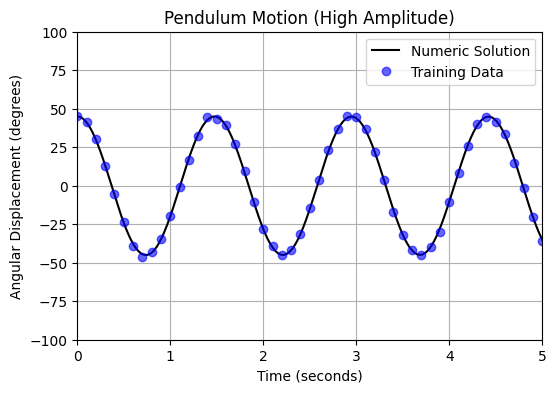

In [6]:
# Visualize dataset
plt.figure(figsize=(6, 4))
plt.plot(t_values, np.degrees(theta_values), "-k", label="Numeric Solution")
plt.plot(t_train, np.degrees(theta_train), "ob", label="Training Data", alpha=0.6)
plt.legend(loc="upper right")
plt.title("Pendulum Motion (High Amplitude)")
plt.xlabel("Time (seconds)")
plt.ylabel("Angular Displacement (degrees)")
plt.axis([0, t_end, -100, 100])
plt.grid()
plt.legend()
plt.show()


## PINNs

### Network Architecture

We wish to have a neural network that can predict the position of a pendulum ($\theta$) in the time domain $0 \leq t \leq 5 \ s$, by minimizing the training data loss, initial condition loss and physics loss. We will have $g$ as a learnable. Since $g$ affects the physics loss, the neural network will use backpropagation to learn the optimal value of $g$ that minimizes the physics loss.

**Architecture :**
- **Input :** time $t$ (single feature)

- **Hidden Layers :** 3 hidden layers with 32 neurons each.

- **Output :** angular displacement $\theta_t$ of the pendulum at time $t$


### `Class` Definition for PINN Model

In [7]:
class PINN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


### `Functions` for Printing Losses and Visualizing Training Progress

In [8]:
#################
# Print Losses
def print_training_losses(epoch, g, loss_total, loss_1, loss_2, loss_3, loss_4):
    print("#"*17)
    print(f"Epoch = {epoch+1}")
    print("#"*17)
    print(f"g = {g.item():.4f} m/s^2")
    print("#"*17)
    print(f"Loss 1 (Physics Loss)   = {loss_1.detach():.4f}")
    print(f"Loss 2 (I.C Loss-1)     = {loss_2.detach():.4f}")
    print(f"Loss 3 (I.C Loss-2)     = {loss_3.detach():.4f}")
    print(f"Loss 4 (Data Loss)      = {loss_4.detach():.4f}")
    print(f"Loss Total              = {loss_total.detach():.4f}")
    print("#"*17)

    return()


#################
# Plot comparison of PINN's prediction with validation data  
def plot_training_progress(epoch, model_pinns, t_valid, theta_valid):
       
    # Theta prediction for validation dataset
    theta_obs_pred = model_pinns(t_valid).detach()

    plt.figure(figsize=(5, 2.5))
    plt.scatter(t_valid[:, 0], np.degrees(theta_valid[:,0]), label="Training Data", alpha=0.6)
    plt.plot(t_valid[:, 0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="g")

    plt.title(f"Training step {epoch+1}", fontsize=10)        
    plt.xlabel("Time (in s)", fontsize=8)
    plt.ylabel("Theta (in deg)", fontsize=8)

    plt.axis([0, t_end, -100, 100])
    plt.legend(fontsize="small")
    plt.show()

    return()


### Training

**Loss Function :** <br>
The derivatives $d\theta/dt$ and $d^2\theta/dt^2$ will be computed by leveraging PyTorch's automatic differention capibility via its inbuilt function `torch.autograd`. Our training dataset comprises of $51$ uniformaly distributed data points in the domain $t \in [0,\ 5]$. We will compute the following four losses:
- `loss_1` : Physics Loss; Using the governing ODE for all $t \ge 0$.
- `loss_2` : Initial Condition 1; $\theta_0 = 45\degree$.
- `loss_3` : Initial Condition 2; $\omega_0 = 0\ rad/s$.
- `loss_4` : Training data from (artificial) experiment;

The magnitude of the above four losses vary largely in magnitude and thus each of them will be multiplied with a weight coefficient `coeff_i` which has been found after some trial and error. 

**Computing $g$ :** <br>
A PyTorch tensor of type `nn.parameter` called `g` has been created, with `requires_grad` set to `True`. Its value has been initialized randomly. This has been assigned to the optimiser as a parameter that it must optimize through backpropagation.


#################
Epoch = 1
#################
g = 4.0706 m/s^2
#################
Loss 1 (Physics Loss)   = 7.4018
Loss 2 (I.C Loss-1)     = 6.2939
Loss 3 (I.C Loss-2)     = 1.0088
Loss 4 (Data Loss)      = 324.2509
Loss Total              = 338.9554
#################


C:\Users\E40065690\AppData\Local\Temp\ipykernel_27236\2512479475.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.scatter(t_valid[:, 0], np.degrees(theta_valid[:,0]), label="Training Data", alpha=0.6)
C:\Users\E40065690\AppData\Local\Temp\ipykernel_27236\2512479475.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(t_valid[:, 0], np.degrees(theta_obs_pred[:,0]), label="PINN Solution", color="g")


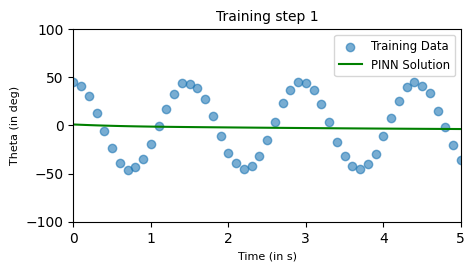

#################
Epoch = 2500
#################
g = 9.7221 m/s^2
#################
Loss 1 (Physics Loss)   = 1.4660
Loss 2 (I.C Loss-1)     = 0.0000
Loss 3 (I.C Loss-2)     = 0.0002
Loss 4 (Data Loss)      = 0.4636
Loss Total              = 1.9298
#################


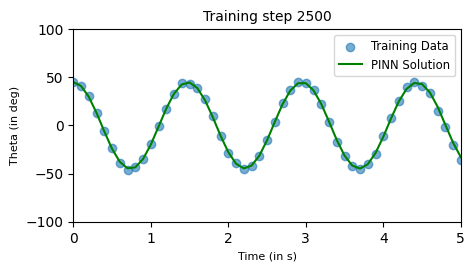

#################
Epoch = 5000
#################
g = 9.8182 m/s^2
#################
Loss 1 (Physics Loss)   = 0.2306
Loss 2 (I.C Loss-1)     = 0.0001
Loss 3 (I.C Loss-2)     = 0.0019
Loss 4 (Data Loss)      = 0.2682
Loss Total              = 0.5009
#################


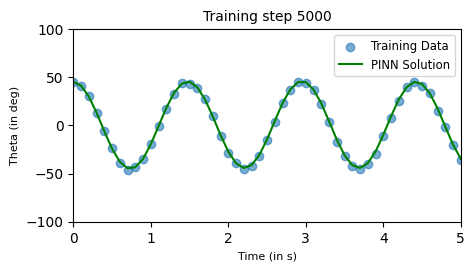

#################
Epoch = 7500
#################
g = 9.8291 m/s^2
#################
Loss 1 (Physics Loss)   = 0.0252
Loss 2 (I.C Loss-1)     = 0.0003
Loss 3 (I.C Loss-2)     = 0.0000
Loss 4 (Data Loss)      = 0.1927
Loss Total              = 0.2182
#################


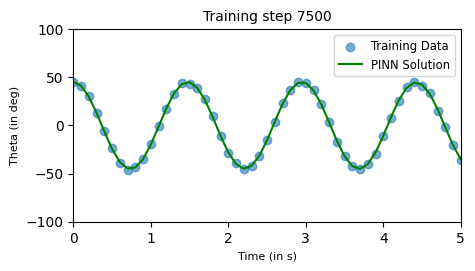

In [9]:
# Set random seed for result reproducibility
torch.manual_seed(42)

# Ensure all tensors have the correct dtype
t_train = t_train.float()
theta_train = theta_train.float()

# Define a neural network to train
model_pinns = PINN(1, 1, 32, 3)

# Define training points over the entire domain, for the physics loss
t_physics = torch.linspace(t0, t_end, 51).view(-1,1).requires_grad_(True)

# Initial condition
theta_init = torch.from_numpy( np.radians(45).reshape(1, 1) ) # in radians
dtheta_dt_init = torch.zeros(1, 1) # in rad/s

# Treat "g" as a learnable parameter
g  = torch.nn.Parameter(torch.rand(1, requires_grad=True)*10)
g_arr = []

# Define the optimizer with separate parameter groups
optimiser = torch.optim.Adam([
    {'params': model_pinns.parameters(), 'lr': 1e-3},   # Learning rate for the weights and biases
    {'params': [g], 'lr': 1e-2}                         # Learning rate for "g"
])

# Weight coefficients for various losses
coeff_1 = 10    # weight coeff for "loss_1" : physics loss
coeff_2 = 10   # weight coeff for "loss_2" : initial condition-1
coeff_3 = 100  # weight coeff for "loss_3" : initial condition-2
coeff_4 = 1000 # weight coeff for "loss_4" : data loss

##############
for epoch in range(7500):
    
    # Set gradients to 0
    optimiser.zero_grad()

    # compute physics loss
    theta_pred = model_pinns(t_physics)
    dtheta_dt_pred = torch.autograd.grad(theta_pred, t_physics, torch.ones_like(theta_pred), create_graph=True)[0]
    d2theta_dt2_pred = torch.autograd.grad(dtheta_dt_pred, t_physics, torch.ones_like(dtheta_dt_pred), create_graph=True)[0]
    loss_1 = coeff_1 * torch.mean( ( d2theta_dt2_pred + g/L*torch.sin(theta_pred) )**2 ) # for all t >= 0 
    
    # initial condition (theta = 45 deg)
    loss_2 = coeff_2 * torch.mean((theta_pred[0] - theta_init)**2)

    # boundary condition (dtheta_dt = 0)   
    loss_3 = coeff_3 * torch.mean((dtheta_dt_pred[0] - dtheta_dt_init)**2)

    # boundary condition (dtheta_dt = 0)   
    loss_4 = coeff_4 * torch.mean((theta_pred - theta_train)**2)

    # backpropagate joint loss, take optimiser step
    loss_total = loss_1 + loss_2 + loss_3 + loss_4
    loss_total.backward()
    optimiser.step()
    
    # record "g" value
    g_arr.append(g.item())

    # plot the result as training progresses
    if (epoch+1) % 2500 == 0 or epoch == 0 :
        print_training_losses(epoch, g, loss_total, loss_1, loss_2, loss_3, loss_4)
        plot_training_progress(epoch, model_pinns, t_train, theta_train)
        


## Inference

**Note :** <br>
Since we added $2\%$ noise to the data obtained from RK45 numerical method, we will not obtain the exact value of $9.81\ m/s$. Nevertheless, we observe that the network started with the random value of $g \approx 4.07\ m/s^2$ managed to converge to $g \approx 9.83\ m/s^2$. 

In [10]:
print("#"*17)
print(f"PINN based estimation of 'g' : {g.item():.4f} m/s^2.")
print("#"*17)


#################
PINN based estimation of 'g' : 9.8291 m/s^2.
#################
